In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd

####  The dataset can be downloaded from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [2]:
filepath = './data/sentiment_analysis/yelp_labelled.txt'
df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t') # read the csv file 

#### Train test split with 80:20 ratio

In [3]:
from sklearn.model_selection import train_test_split

sentences = df['sentence'].values #.values returns a numpy array instead of pandas series
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=42)

### Word embeddings

#### Words are represented as vectors. Word embedding maps semantic meaning of a word in a sentence into a geometric space. #### This maps semantically similar words close in a geometric / embedding space. In this notebook, I will train word embedding #### during the training of my model

#### Keras Tokenizer class vectorizes texts into a list of integers that maps to a value in a dictionary where the corresponding key is the term in the vocabulary.

In [4]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000) # sets the size of the vocablary (most common num_words)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[10])
print(X_train[10])

Using TensorFlow backend.


Great food and service, huge portions and they give a military discount.
[19, 11, 2, 18, 306, 264, 2, 35, 188, 5, 781, 782]


#### All texts are of different length. pad_sequence() appends/prepends the vector of words with 0s to make it same length.

In [5]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  1 137   4   1 303 369   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


#### Keras Embedding Layer takes the previously calculated integers and maps them to a dense vector. 
#### Global max-pooling layer reduces the size of the incoming feature vectors.

In [6]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           91250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 91,771
Trainable params: 91,771
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X_train, y_train, epochs=50, verbose=False,
                    validation_data=(X_test, y_test), batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.8250


In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Number of epochs')
    plt.xlabel('Accuracy')
    plt.legend()

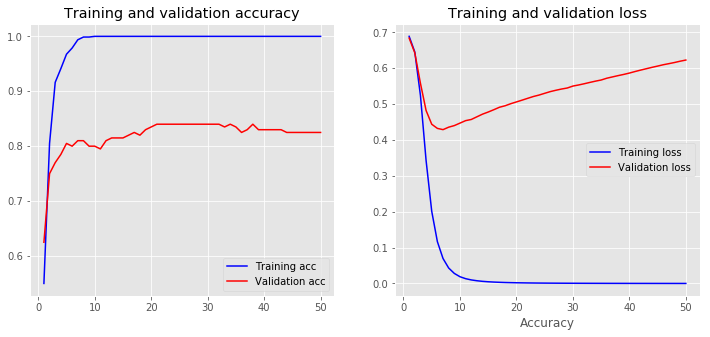

In [9]:
plot_history(history)

#### It can be seen that the model is overfitting as the training accracy is 100%. The loss of validation set has also gone up after 10 #### epochs